In [1]:
import torch, torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from DiffusionModelspytorch.modules import UNet
from torch import nn
import math
from torchvision import transforms 
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch.optim import Adam
from PIL import Image
import os
import shutil
from torchvision import transforms

def show_images(dataset,num_samples=20,cols=4):
    plt.figure(figsize=(15,15))
    for i , img in enumerate(data):
        if i==num_samples:
                break
        plt.subplot(int(num_samples/cols)+1,cols,i+1)
        plt.imshow(img[0])
  
    return 0


def path_walker(root_path,file_select):
    a=os.walk(root_path)
    file_paths=[]
    for i,j,k in a:
        for z in k:
            if(z.endswith(file_select)==False):
                continue
            file_path=os.path.join(i,z)
            file_paths.append(file_path)
    return file_paths

In [2]:
class MyImages(Dataset):
    def __init__(self, images_dirs, image_size,transform=False):
        self.images_dir=[]
        if type(images_dirs)==list:
            for i in images_dirs:
                self.images_dir.extend(path_walker(i,".jpg"))
        else:
             self.images_dir= path_walker(images_dirs,".jpg")
        
        self.transform = transform
        self.image_size = image_size
        self.transform_pipeline=get_transform(self.image_size)
        
    def __len__(self):
        
        return len(self.images_dir)
    
    def __getitem__(self, idx):

        image = Image.open(self.images_dir[idx]).convert('RGB')

        data_transforms =  self.transform_pipeline(image)
        
        return  data_transforms
        
def get_transform(img_size):
    transform_list = [
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(), # Scales data into [0,1] 
                transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
                ]
    return transforms.Compose(transform_list)

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [4]:
IMG_SIZE = 32
BATCH_SIZE = 64

def load_transformed_dataset():
    imgs_path=["icartoonface/test_set/test","icartoonface/train_set/train"]
    dataset=MyImages(imgs_path,IMG_SIZE)
        
    return dataset

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

C:\Users\Barath\AppData\Local\Temp\ipykernel_15616\3596907728.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


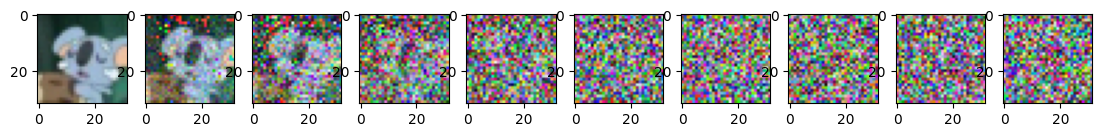

In [5]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)
    
    
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [6]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  23332739


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        )
      )
      (2): DoubleConv(
        (double_conv): Sequential(
        

In [7]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

0
Epoch 0 | step 000 Loss: 0.8597413897514343 


C:\Users\Barath\AppData\Local\Temp\ipykernel_15616\364762590.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


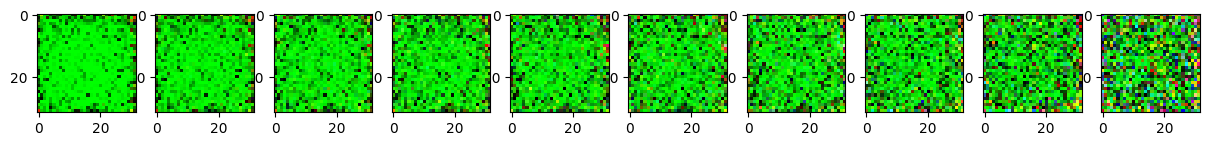

1
2
3
4
5
Epoch 5 | step 000 Loss: 0.147029846906662 


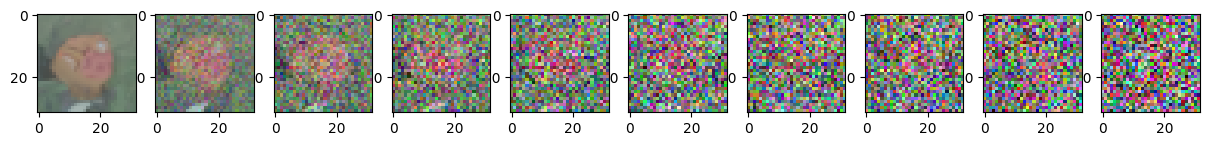

6
7
8
9
10
Epoch 10 | step 000 Loss: 0.16925948858261108 


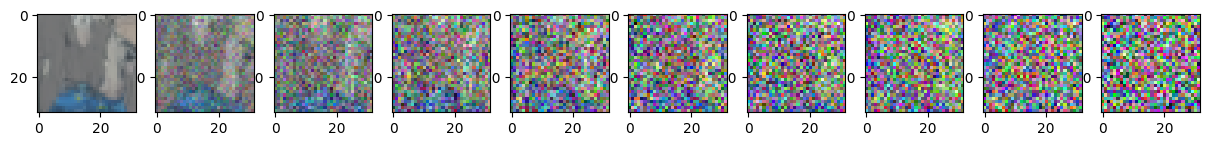

11
12
13
14
15
Epoch 15 | step 000 Loss: 0.14916661381721497 


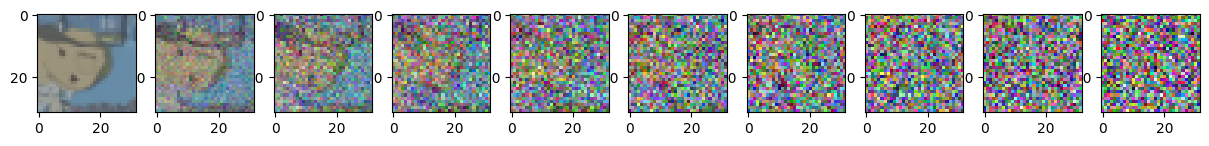

16
17
18
19
20
Epoch 20 | step 000 Loss: 0.1411268562078476 


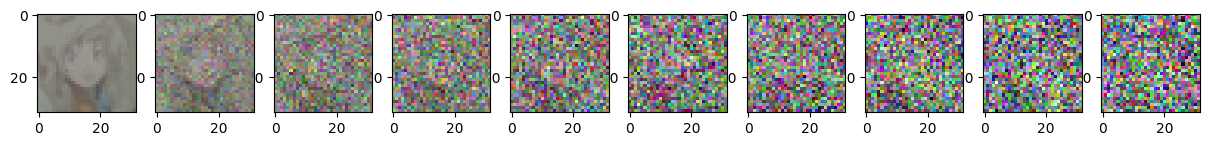

21
22
23
24
25
Epoch 25 | step 000 Loss: 0.14232170581817627 


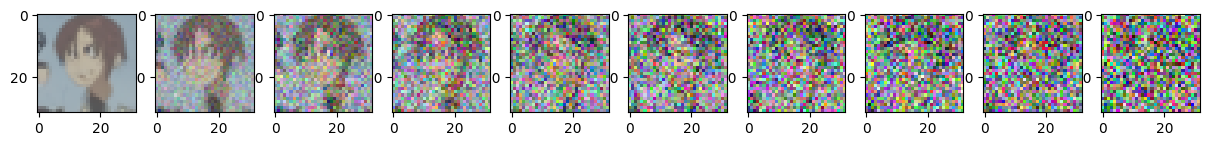

26
27
28
29
30
Epoch 30 | step 000 Loss: 0.1464615911245346 


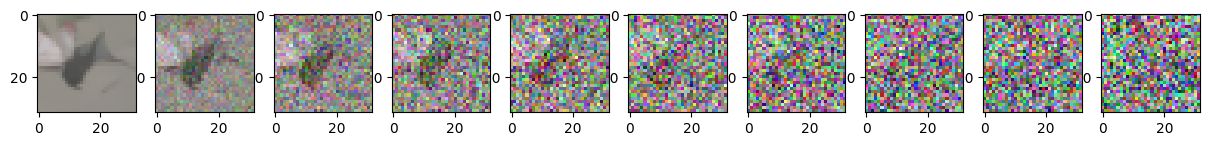

31
32
33
34
35
Epoch 35 | step 000 Loss: 0.1511896550655365 


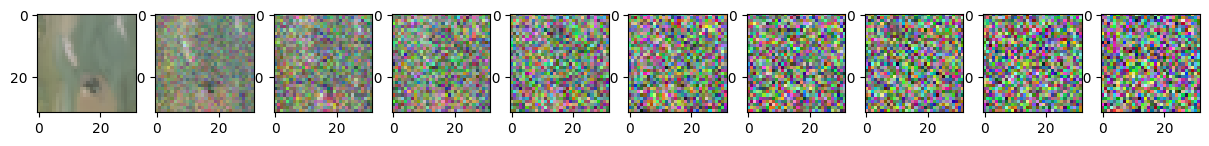

KeyboardInterrupt: 

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 500 # Try more!

for epoch in range(epochs):
  print(epoch)
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch, t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image()

C:\Users\Barath\AppData\Local\Temp\ipykernel_15616\364762590.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


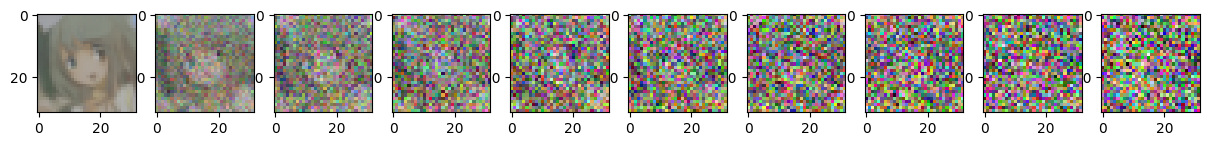

In [16]:
sample_plot_image()